# **Advanced Feature Engineering in Keras**

**Learning Objectives**

1. Process temporal feature columns in Keras
2. Use Lambda layers to perform feature engineering on geolocation features
3. Create bucketised and crossed feature columns

## **Introduction**

In this notebook, we use Keras to build a taxifare price predition model and utilise feature engineering to improve the fare amount prediction for NYC taxi cab rides.

## **Load necessary libraries**

In [1]:
import datetime
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

logging.getLogger("tensorflow").setLevel(logging.ERROR)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.4.1


## **Load Taxi Fare data set**

The Taxi Fare data set for this lab is 106,545 rows and has been pre-processed and split for use in this lab. The `fare_amount` is the target, the continuous value we'll train a model to predict.

First, let's observe the `.csv` data by copying the data from a Cloud Storage bucket.

In [2]:
!ls -l data/taxi*.csv

-rw-r--r-- 1 antounes antounes 122483 mars  29 09:18 data/taxi-test.csv
-rw-r--r-- 1 antounes antounes 573503 mars  29 09:19 data/taxi-train.csv
-rw-rw-r-- 1 antounes antounes 121999 mars  29 09:19 data/taxi-valid.csv


In [3]:
!head data/taxi*.csv

==> data/taxi-test.csv <==
fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key
6,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.7694816589356,-73.9894943237305,40.7397422790527,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8

==> data/taxi-train.csv <==
fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key
11.3,2011-01-28 20:42:59

## **Create an input pipeline**

Typically, you will use a 2-step process to build the pipeline.
- Step one is to define the columns of data; i.e., which column we're predicting for, and the default values.
- Step two is to define two functions $-$ a function to define the features and label you want to use, and a function to load the training data.
Also, note that `pickup_datetime` is a string and we will need to handle this in our feature engineered model.

In [4]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key"
]
LABEL_COLUMN = "fare_amount"
STRING_COLS = ["pickup_datetime"]
NUMERIC_COLS = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count"]
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
DAYS = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]

In [5]:
# A function to define features and labels
def features_and_labels(row_data):
    for unwanted_col in ["key"]:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label

# A utility method to create a tf.data data set from a Pandas DataFrame
def load_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(pattern,
                                                    batch_size,
                                                    CSV_COLUMNS,
                                                    DEFAULTS)
    dataset = dataset.map(features_and_labels) # features, label
    if mode == "train":
        dataset = dataset.shuffle(1000).repeat()
        # take advantage of multi-threading; 1 = AUTOTUNE
        dataset = dataset.prefetch(1)
    return dataset

## **Baseline DNN Model in Keras**

### **Create the model**

Now let's build the Deep Neural Network (DNN) model in Keras using the functional API. Unlike the sequential API, we will need to specify the input and hidden layers. Note that we are creating a linear regression baseline model with no feature engineering. Recall that a baseline model is a solution to a problem without applying any ML techniques.

In [6]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    # Root mean squared error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def build_dnn_model():
    # Input layer
    inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype="float32")
        for colname in NUMERIC_COLS
    }
    
    # Feature columns
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in NUMERIC_COLS
    }
    
    # Constructor for DenseFeatures takes a list of numeric columns
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)
    
    # Two hidden layers of [32, 8]
    h1 = tf.keras.layers.Dense(32, activation="relu", name="h1")(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation="relu", name="h2")(h1)
    
    # Final output is a linear activation beacause this is regression
    output = tf.keras.layers.Dense(1, activation="linear", name="fare")(h2)
    model = tf.keras.models.Model(inputs, output)
    
    # Compile model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    
    return model

We'll build our DNN model and inspect the model architecture.

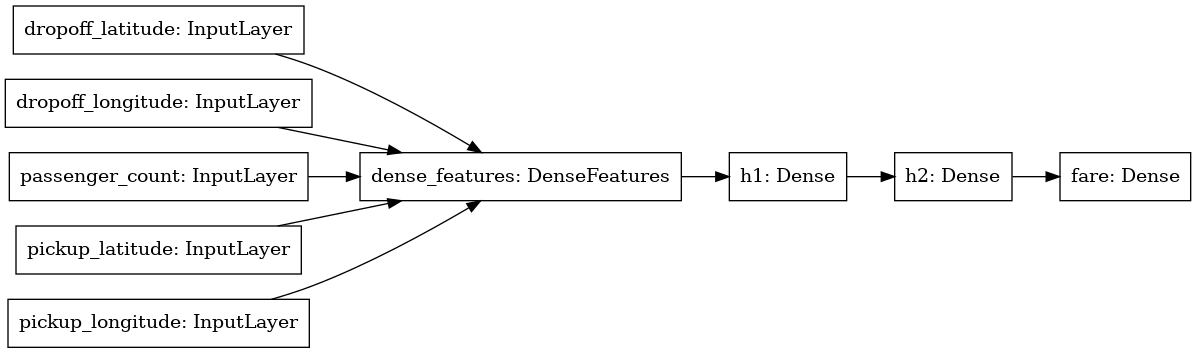

In [7]:
model = build_dnn_model()

# We can visualise the DNN using the Keras `plot_model` utility
tf.keras.utils.plot_model(model, "models/dnn_model.png", show_shapes=False, rankdir="LR")

### **Train the model**

To train the model, simply call [`model.fit()`](https://keras.io/models/model/#fit). Note that we should really use many more `NUM_TRAIN_EXAMPLES` (i.e. a larger data set). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

We start by setting up the environment variables for training, creating the input pipeline data sets, and then train our baseline DNN model.

In [8]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 59621 * 5
NUM_EVALS = 5
NUM_EVAL_EXAMPLES = 14906

In [9]:
# `load_dataset()` method is used to load the data set
trainds = load_dataset("data/taxi-train*", 
                       TRAIN_BATCH_SIZE, 
                       "train")
evalds = load_dataset("data/taxi-valid*", 
                      1000, 
                      "eval").take(NUM_EVAL_EXAMPLES//1000)
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

# `.fit()` trains the model for a fixed number of epochs
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/5


/home/antounes/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['pickup_datetime'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


1863/1863 [==============================] - 5s 2ms/step - loss: 137.5543 - rmse: 10.4459 - mse: 137.5543 - val_loss: 110.5008 - val_rmse: 10.4931 - val_mse: 110.5008
Epoch 2/5
1863/1863 [==============================] - 4s 2ms/step - loss: 96.0254 - rmse: 9.2132 - mse: 96.0254 - val_loss: 110.9705 - val_rmse: 10.5210 - val_mse: 110.9705
Epoch 3/5
1863/1863 [==============================] - 4s 2ms/step - loss: 102.3642 - rmse: 9.3093 - mse: 102.3642 - val_loss: 111.0141 - val_rmse: 10.5120 - val_mse: 111.0141
Epoch 4/5
1863/1863 [==============================] - 3s 2ms/step - loss: 92.1374 - rmse: 9.0386 - mse: 92.1374 - val_loss: 110.6209 - val_rmse: 10.5055 - val_mse: 110.6209
Epoch 5/5
1863/1863 [==============================] - 4s 2ms/step - loss: 96.0256 - rmse: 9.1661 - mse: 96.0256 - val_loss: 110.1126 - val_rmse: 10.4855 - val_mse: 110.1126


### **Visualise the model loss curve**

Next, we will use matplotlib to draw the model's loss curves for training and validation. A line plot is also created showing the mean squared error loss over the training epochs for both the train (blue) and validation (orange) sets.

In [10]:
# A function to define `plot_curves`
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))
    
    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history["val_{}".format(key)])
        plt.title("model {}".format(key))
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left");

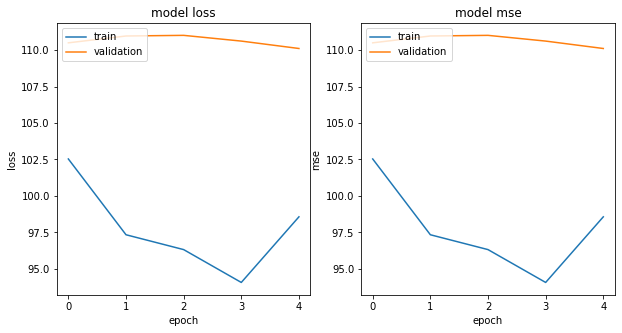

In [11]:
plot_curves(history, ["loss", "mse"])

### **Predict with the model locally**

To predict with Keras, you simply call [`model.predict()`](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for. Next we note the fare price at this geolocation and `pickup_datetime`.

In [12]:
# Use the model to do prediction with `model.predict()`
model.predict({
    "pickup_longitude": tf.convert_to_tensor([-73.982683]),
    "pickup_latitude": tf.convert_to_tensor([40.742104]),
    "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
    "dropoff_latitude": tf.convert_to_tensor([40.755174]),
    "passenger_count": tf.convert_to_tensor([3.0]),
    "pickup_datetime": tf.convert_to_tensor(["2010-02-08 09:17:00 UTC"], dtype=tf.string),
}, steps=1)

array([[11.446686]], dtype=float32)

## **Improve Model Performance Using Feature Engineering**

We now improve our model's performance by creating the following feature engineering types: Temporal, Categorical, and Geolocation.

### **Temporal Feature Columns**

We incorporate the temporal feature `pickup_datetime`. As noted earlier, `pickup_datetime` is a `str` and we will need to handle this within the model. First, you will include the `pickup_datetime` as a feature and then you will need to modify the model to handle our string feature.

In [13]:
def parse_datetime(s):
    if type(s) is not str:
        s = s.numpy().decode("utf-8")
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")

def get_dayofweek(s):
    ts = parse_datetime(s)
    return DAYS[ts.weekday()]

@tf.function
def dayofweeks(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in)

### **Geolocation/Coordinate Feature Columns**

The pick-up/drop-off longitude and latitude data are crucial to predicting the fare amount as fare amounts in NYC taxis are largely determined by the distance traveled. As such, we need to teach the model the Euclidean distance between the pick-up and drop-off points.

Recall that latitude and longitude allows us to specify any location on Earth using a set of coordinates. In our training data set, we restricted our data points to only pickups and drop offs within NYC. New York City has an approximate longitude range of `-74.05` to `-73.75` and a latitude range of `40.63` to `40.85`.

#### **Computing Euclidean distance**

The data set contains information regarding the pick up and drop off coordinates. However, there is no information regarding the distance beteween the pick up and drop off points. Therefore, we create a new feature that calculates the distance between each pair of pick up and drop off points. We can do this using the Euclidean distance, which is the straight-line distance between any two coordinate points.

In [14]:
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff**2 + latdiff**2)

#### **Scaling latitude and longitude**

It is very important for numerical variables to get scaled before they are *fed* into the neural network. Here we use *min-max scaling* (also called *normalisation*) on the geolocation features. Later in our model, you will see that these values are shifted and rescaled so that they end up ranging from `0` to `1`.

First, we create a function named `scale_longitude`, where we pass in all the longitudinal values and add `78` to each value. Note that our scaling longitude ranges from `-70` to `-78`, thus, the value `78` is the maximum longitudinal value. The delta between `-70` and `-78` is `8`. We add `78` to each longitudinal value and then divide by `8` to return a scaled value.

In [15]:
def scale_longitude(lon_column):
    return (lon_column + 78)/8

Next, we create a function named `scale_latitude`, where we pass in all the latitudinal values and subtract `37` from each value. Note that our scaling latitude ranges from `-37` to `-45`. Thus, the value `37` is the minimal latitudinal value. The delta between `-37` and `-45` is `8`. We subtract `37` from each latitudinal value and then divide by `8` to return a scaled value.

In [16]:
def scale_latitude(lat_column):
    return (lat_column - 37)/8

### **Putting it all together**

We now create two new *geo* functions for our model. We create a function called `euclidean` to initialise our geolocation parameters. We then create a function called `transform`. The `transform` function passes our numerical and `str` column features as inputs to the model, scales geolocation features, then creates the Euclidean distance as a transformed variable with the geolocation features. Lastly, we bucketise the latitude and longitude features.

In [21]:
def transform(inputs, numeric_cols, string_cols, nbuckets):
    print("Inputs before features transformation: {}".format(inputs.keys()))
    
    # Pass-through columns
    transformed = inputs.copy()
    del transformed["pickup_datetime"]
    
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in numeric_cols
    }
    
    # Scaling longitude from range [-70, 78] to [0, 1]
    for lon_col in ["pickup_longitude", "dropoff_longitude"]:
        transformed[lon_col] = tf.keras.layers.Lambda(
            scale_longitude,
            name="scale_{}".format(lon_col))(inputs[lon_col])
    
    # Scaling latitude from range [37, 45] to [0, 1]
    for lat_col in ["pickup_latitude", "dropoff_latitude"]:
        transformed[lat_col] = tf.keras.layers.Lambda(
            scale_latitude,
            name="scale_{}".format(lat_col))(inputs[lat_col])
        
    # Add Euclidean distance
    transformed["euclidean"] = tf.keras.layers.Lambda(
        euclidean,
        name="euclidean")([inputs["pickup_longitude"],
                           inputs["pickup_latitude"],
                           inputs["dropoff_longitude"],
                           inputs["dropoff_latitude"]])
    feature_columns["euclidean"] = tf.feature_column.numeric_column("euclidean")
    
    # Create bucketised features
    latbuckets = np.linspace(0, 1, nbuckets).tolist()
    lonbuckets = np.linspace(0, 1, nbuckets).tolist()
    b_plat = tf.feature_column.bucketized_column(
        feature_columns["pickup_latitude"], latbuckets)
    b_dlat = tf.feature_column.bucketized_column(
        feature_columns["dropoff_latitude"], latbuckets)
    b_plon = tf.feature_column.bucketized_column(
        feature_columns["pickup_longitude"], lonbuckets)
    b_dlon = tf.feature_column.bucketized_column(
        feature_columns["dropoff_longitude"], lonbuckets)
    
    # Create crossed columns
    ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
    dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
    pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4)
    
    # Create embedding columns
    feature_columns["pickup_and_dropoff"] = tf.feature_column.embedding_column(pd_pair, 100)
    
    print("Transformed features: {}".format(transformed.keys()))
    print("Feature columns: {}".format(feature_columns.keys()))
    return transformed, feature_columns

Next, we will create our DNN model now with the engineered features. We will set `NBUCKETS = 10` to specify 10 buckets when bucketising the latitude and longitude.

In [24]:
NBUCKETS = 10

# DNN MODEL
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def build_dnn_model():
    # Input layer is all float except for pickup_datetime which is a string
    inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype="float32")
        for colname in NUMERIC_COLS
    }
    inputs.update({
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype="string")
        for colname in STRING_COLS
    })
    
    # Transforms
    transformed, feature_columns = transform(inputs,
                                             numeric_cols=NUMERIC_COLS,
                                             string_cols=STRING_COLS,
                                             nbuckets=NBUCKETS)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)
    
    # Two hidden layers of [32, 8]
    h1 = tf.keras.layers.Dense(32, activation="relu", name="h1")(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation="relu", name="h2")(h1)
    
    # Final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation="linear", name="fare")(h2)
    model = tf.keras.models.Model(inputs, output)
    
    # Compile model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    return model

In [25]:
model = build_dnn_model()

Inputs before features transformation: dict_keys(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime'])
Transformed features: dict_keys(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'euclidean'])
Feature columns: dict_keys(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'euclidean', 'pickup_and_dropoff'])


Let's see how our model architecture has changed now.

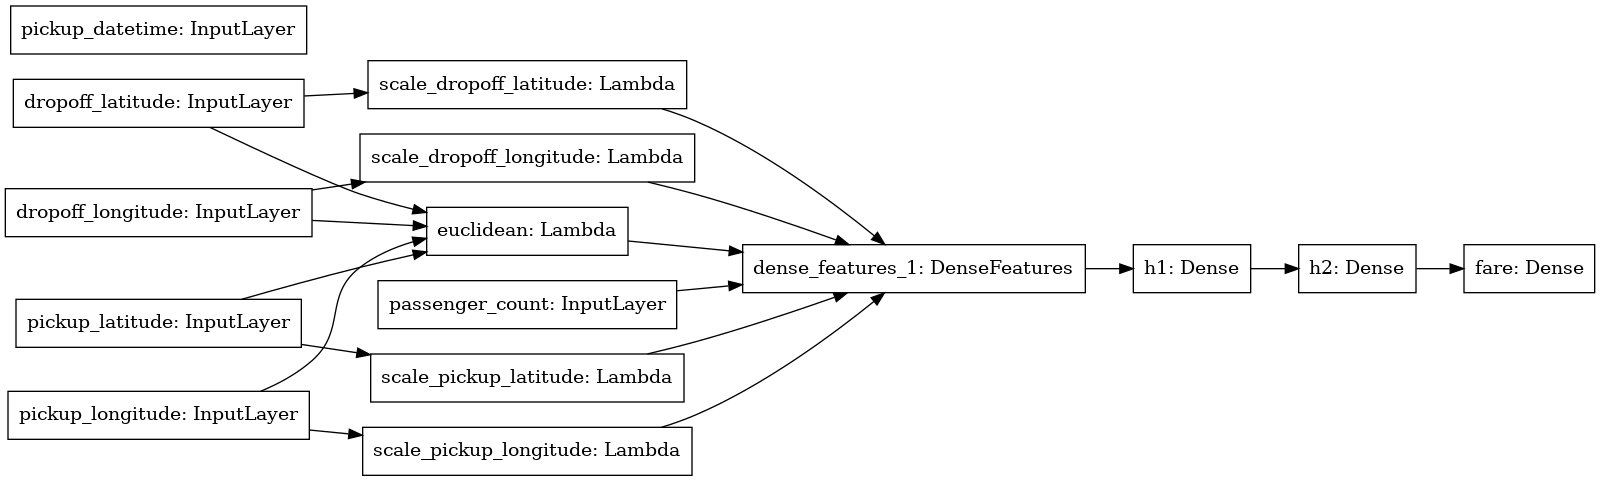

In [27]:
# We can visualise the DNN using the Keras `plot_model` utility
tf.keras.utils.plot_model(model, "dnn_model_engineered.png", show_shapes=False, rankdir="LR")

### **Train the model**

In [ ]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 59621 * 5
NUM_EVALS = 5
NUM_EVAL_EXAMPLES = 14906

In [28]:
# `load_dataset` method is used to load the data set
trainds = load_dataset("data/taxi-train*",
                       TRAIN_BATCH_SIZE,
                       "train")
evalds = load_dataset("data/taxi-valid*",
                      1000,
                      "eval").take(NUM_EVAL_EXAMPLES//1000)
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

# `.fit()` trains the model for a fixed number of epochs
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EVALS+3,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/8
1863/1863 [==============================] - 46s 24ms/step - loss: 112.7373 - rmse: 9.9147 - mse: 112.7373 - val_loss: 101.6780 - val_rmse: 10.0648 - val_mse: 101.6780
Epoch 2/8
1863/1863 [==============================] - 54s 29ms/step - loss: 76.3376 - rmse: 8.1641 - mse: 76.3376 - val_loss: 44.6388 - val_rmse: 6.6431 - val_mse: 44.6388
Epoch 3/8
1863/1863 [==============================] - 37s 20ms/step - loss: 33.0499 - rmse: 4.7984 - mse: 33.0499 - val_loss: 27.1960 - val_rmse: 5.1984 - val_mse: 27.1960
Epoch 4/8
1863/1863 [==============================] - 41s 22ms/step - loss: 26.8994 - rmse: 4.1500 - mse: 26.8994 - val_loss: 27.1334 - val_rmse: 5.1900 - val_mse: 27.1334
Epoch 5/8
1863/1863 [==============================] - 41s 22ms/step - loss: 26.5239 - rmse: 4.2009 - mse: 26.5239 - val_loss: 26.6464 - val_rmse: 5.1426 - val_mse: 26.6464
Epoch 6/8
1863/1863 [==============================] - 36s 19ms/step - loss: 21.6343 - rmse: 3.8773 - mse: 21.6343 - val_loss: 26.

### **Visualise the model loss curve**

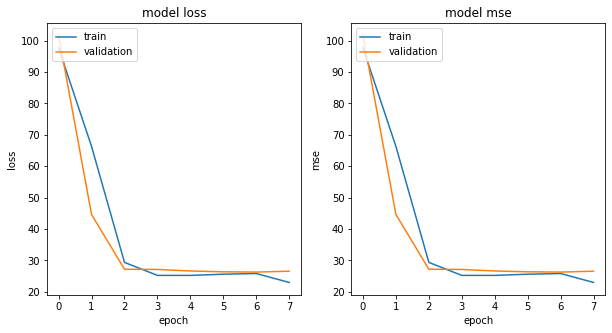

In [30]:
plot_curves(history, ["loss", "mse"])

### **Predict with the model locally**

Let's try a prediction with this new model with engineered features on the example we had above

In [31]:
# Use the model to do prediction with `model.predict()`
model.predict({
    "pickup_longitude": tf.convert_to_tensor([-73.982683]),
    "pickup_latitude": tf.convert_to_tensor([40.742104]),
    "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
    "dropoff_latitude": tf.convert_to_tensor([40.755174]),
    "passenger_count": tf.convert_to_tensor([3.0]),
    "pickup_datetime": tf.convert_to_tensor(["2010-02-08 09:17:00 UTC"], dtype=tf.string),
}, steps=1)

array([[7.284939]], dtype=float32)

## **Summary**

Below we summarise our training results comparing our baseline model with our model with engineered features.

|**Model**|**Train RMSE**|**Valdiation RMSE**|**Description**|
|:-:|:-:|:-:|:-:|
|Baseline| `9.1661` | `10.4855` | Baseline model - no feature engineering|
|Feature Engineered | `3.8770` | `5.1065` | Feature engineered model|